In [1]:
import sys
import os
import time
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/public/workspace/ruru_97/projects/schgnn/csMAHN')
import utils.preprocess as pp
from utils.utility import *
from utils.train import Trainer
from utils.plot import plot_umap

import importlib as im
im.reload(pp)

<module 'utils.preprocess' from '/public/workspace/ruru_97/projects/schgnn/csMAHN/utils/preprocess.py'>

In [2]:
reverse=False
aligned=False
tissue = "lung"
gse_ids = ["GSE127465","GSE127465"]
species = ('human', 'mouse')
dsnames = ('human_t', 'mouse_t')
path_data='/public/workspace/ruru_97/projects/data'
resdir='/public/workspace/ruru_97/projects/schgnn/result'
homo_method='biomart'
key_class='cell_type'
n_hvgs=2000
n_degs=50

seed = 123
stages=[200, 200, 200]
nfeats=64  # enbedding size #128
hidden=64 # 128
input_drop=0.2
att_drop=0.2
residual=True

threshold=0.9 # 0.8
lr=0.01  # lr = 0.01
weight_decay=0.001
patience=100
enhance_gama=10
simi_gama=0.1 

In [3]:
# reverse reference to query, query to reference.
if reverse:
    gse_ids = gse_ids[::-1]
    species = species[::-1]
    dsnames = dsnames[::-1]
seed_all(seed)
path_homo = f'{path_data}/homo/{homo_method}/input/{species[0]}_to_{species[1]}.txt'
path_specie_1 = f'{path_data}/ByTissue/{tissue}/{gse_ids[0]}/input/{dsnames[0]}.h5ad'
path_specie_2 = f'{path_data}/ByTissue/{tissue}/{gse_ids[1]}/input/{dsnames[1]}.h5ad'

# make file to save
time_tag = make_nowtime_tag()
curdir = f'{resdir}/{tissue}/{tissue}-{gse_ids[0]}_{dsnames[0]}-{gse_ids[1]}_{dsnames[1]}-{time_tag}'
model_dir = os.path.join(curdir, 'model_')
figdir = os.path.join(curdir, 'fig_')
os.mkdir(curdir)
os.mkdir(figdir)
os.mkdir(model_dir)
checkpt_file = model_dir + "/mutistages"
print(checkpt_file)

for i in range(len(stages)):
    res_dir = os.path.join(curdir, f'res_{i}')
    os.mkdir(res_dir)
homo = pd.read_csv(path_homo)
adata_species_1 = sc.read_h5ad(path_specie_1)
adata_species_2 = sc.read_h5ad(path_specie_2)

if aligned:
    adata_species_1, adata_species_2 = pp.aligned_type([adata_species_1, adata_species_2], 'cell_type')


/public/workspace/ruru_97/projects/schgnn/result/lung/lung-GSE127465_human_t-GSE127465_mouse_t-03-06-09.13.57/model_/mutistages


In [4]:
pp.get_type_counts_info([adata_species_1,adata_species_2],key_class=key_class,dsnames=['human','mouse'])

,human,mouse
cell_type,,
tT cells,12776.0,1491.0
tMoMacDC,9372.0,1768.0
tB cells,5218.0,1874.0
tNeutrophils,2728.0,3593.0
tPlasma cells,2197.0,NaN
Patient1-specific,1307.0,NaN
tNK cells,1116.0,400.0
Patient5-specific,766.0,NaN
tMast cells,732.0,NaN


In [5]:
immune_cell = ['tT cells','tMoMacDC','tB cells','tNeutrophils','tNK cells','tpDC','tBasophils','tMast cells']
adata_species_1 = adata_species_1[adata_species_1.obs['cell_type'].isin(immune_cell)]
adata_species_2 = adata_species_2[adata_species_2.obs['cell_type'].isin(immune_cell)]
adata_species_2.obs['Minor subset'] = 't'+adata_species_2.obs['Minor subset'].astype('string')

In [61]:
print(
    f'Task: refernece:{gse_ids[0]}_{dsnames[0]} {adata_species_1.shape[0]} cells x {adata_species_1.shape[1]} gene -> query:{gse_ids[1]}_{dsnames[1]} {adata_species_2.shape[0]} cells x {adata_species_2.shape[1]} gene in {tissue}')

Task: refernece:GSE127465_human_t 32253 cells x 41861 gene -> query:GSE127465_mouse_t 9201 cells x 28205 gene in lung


In [54]:
start = time.time()
# knn时间较长
adatas, features_genes, nodes_genes, scnets, one2one, n2n = pp.process_for_graph([adata_species_1, adata_species_2],
                                                                                    homo,
                                                                                    'cell_type',
                                                                                    'leiden',
                                                                                    n_hvgs=n_hvgs,
                                                                                    n_degs=n_degs)
g, inter_net, one2one_gene_nodes_net, cell_label, n_classes, list_idx = pp.make_graph(adatas,
                                                                                        aligned,
                                                                                        key_class,
                                                                                        features_genes,
                                                                                        nodes_genes,
                                                                                        scnets,
                                                                                        one2one,
                                                                                        n2n,
                                                                                        has_mnn=True,
                                                                                        seed=seed)
end = time.time()
# 包括预处理时间
print('Times preprocess for graph:{:.2f}'.format(end - start))

Homolog information follows
Mouse homology type
ortholog_one2one      16612
ortholog_many2many     5356
ortholog_one2many      3174
Name: count, dtype: int64
the time2 of processing adatas is 56.75874328613281
Leiden results:
leiden
0     2331
1     1834
2     1574
3     1026
4      715
5      416
6      311
7      303
8      281
9      173
10      90
11      53
12      52
13      22
14      20
Name: count, dtype: int64
the time of leiden is 4.3231494426727295
the time of degs is 311.7402105331421
--------------hvgs, degs info---------------
num of reference_hvgs,reference_degs,reference_higs are 2000,293,2195
num of query_hvgs,query_degs,query_higs are 2000,520,2432
--------------gene nodes info---------------
num of reference_gene_node is 4063
num of query_gene_node is 3360
--------------homo edges---------------
Mouse homology type
ortholog_one2one      2652
ortholog_one2many      293
ortholog_many2many     292
Name: count, dtype: int64
--------------homo edges---------------
Mouse 

In [62]:
import utils.train as train1
im.reload(train1)

<module 'utils.train' from '/public/workspace/ruru_97/projects/schgnn/csMAHN/utils/train.py'>

In [75]:
trainer = train1.Trainer(adatas,
                    g,
                    inter_net,
                    list_idx,
                    cell_label,
                    n_classes,
                    threshold=0.9,
                    weight_decay=0.01,
                    key_class=key_class
                    )
out = trainer.train(curdir=curdir, 
            checkpt_file=checkpt_file,
            stages=[200,200,200],
            best_point_epoch=20,
            patience=100,
            nfeats=nfeats,
            hidden=hidden,
            enhance_gama=enhance_gama,
            simi_gama=simi_gama,
            dsnames=dsnames,
            )

MYHGNN(
  (prelu): PReLU(num_parameters=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (input_drop): Dropout(p=0.2, inplace=False)
  (cell_embedings): ParameterDict(
      (C): Parameter containing: [torch.FloatTensor of size 509x64]
      (CC): Parameter containing: [torch.FloatTensor of size 509x64]
      (CCGGC): Parameter containing: [torch.FloatTensor of size 509x64]
      (CGGC): Parameter containing: [torch.FloatTensor of size 509x64]
      (CGGCC): Parameter containing: [torch.FloatTensor of size 509x64]
      (CCGGCC): Parameter containing: [torch.FloatTensor of size 509x64]
  )
  (cell_project_layers): Sequential(
    (0): Conv1d1x1()
    (1): LayerNorm((6, 64), eps=1e-05, elementwise_affine=True)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv1d1x1()
    (5): LayerNorm((6, 64), eps=1e-05, elementwise_affine=True)
    (6): PReLU(num_parameters=1)
    (7): Dropout(p=0.5, inplace=False)
  )
  (cell_semantic_aggr_layers): Transformer(
    (

In [7]:
embedding = torch.load('/public/workspace/ruru_97/projects/schgnn/result/lung/lung-GSE127465_human_t-GSE127465_mouse_t-03-05-18.44.07/model_/mutistages_best_embedding_2.pt')

In [10]:
adt = sc.AnnData(embedding.detach().numpy())
adatas = [adata_species_1,adata_species_2]
adt.obs['cell_type'] = adatas[0].obs[key_class].tolist() + adatas[1].obs[key_class].tolist()
adt.obs['dataset'] = [dsnames[0]] * adatas[0].shape[0] + [dsnames[1]] * adatas[1].shape[0]
sc.set_figure_params(dpi_save=100)
sc.settings.figdir = figdir
sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)

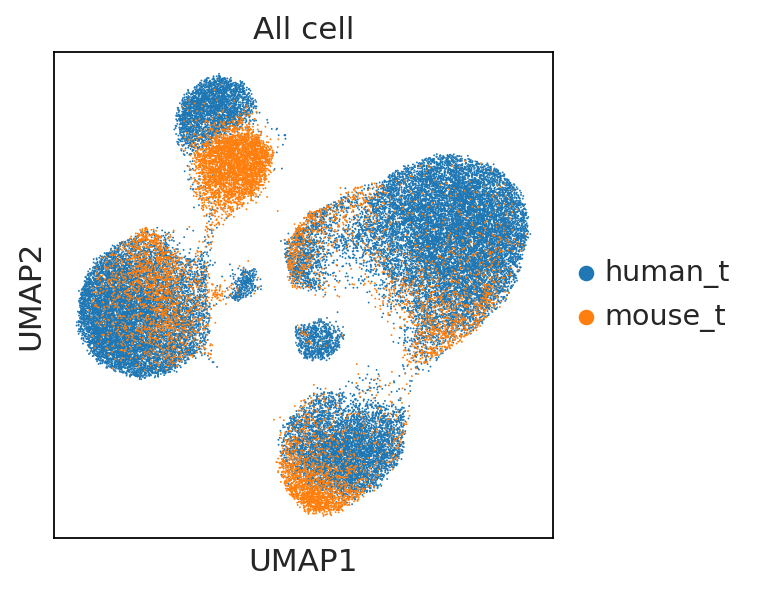

In [78]:
sc.pl.umap(adt,color='dataset',title='All cell')

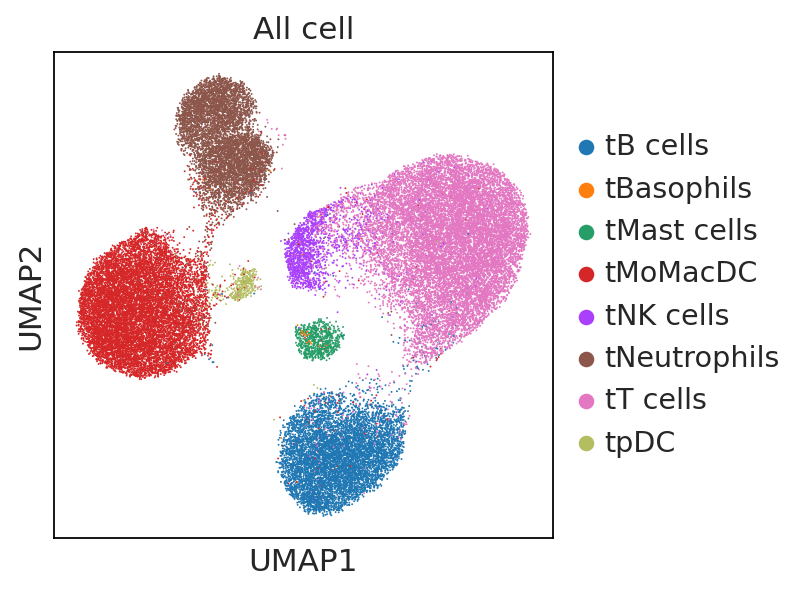

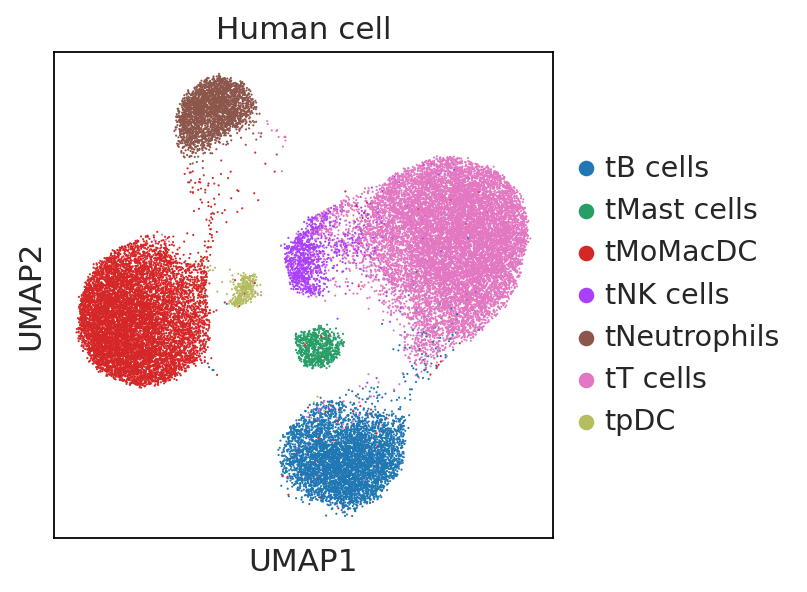

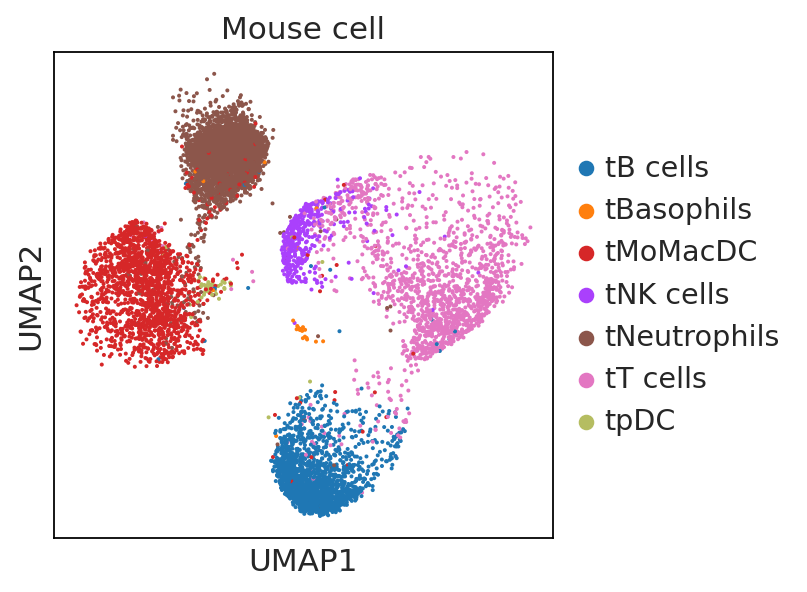

In [79]:
sc.pl.umap(adt,color='cell_type',title='All cell')
sc.pl.umap(adt[:adata_species_1.shape[0]],color='cell_type',title='Human cell')
sc.pl.umap(adt[adata_species_1.shape[0]:],color='cell_type',title='Mouse cell')

In [80]:
df = pd.DataFrame(data=None)
df['true_label'] = np.concatenate(pp.get_labels_from_adatas(trainer.adatas, trainer.key_class))
df['pre_label'] = trainer.output.argmax(dim=-1).detach().numpy()
df['pre_label'].replace(trainer.encode_and_types[0], trainer.encode_and_types[1], inplace=True)
df = df[trainer.adatas[0].shape[0]:]
df['count'] = 1
confuse_matrix = df.pivot_table(index='true_label', columns='pre_label', values='count', aggfunc='sum').fillna(0).astype(int)
confuse_matrix_pro = confuse_matrix.div(confuse_matrix.sum(axis=1),axis=0)

<Axes: xlabel='pre_label', ylabel='true_label'>

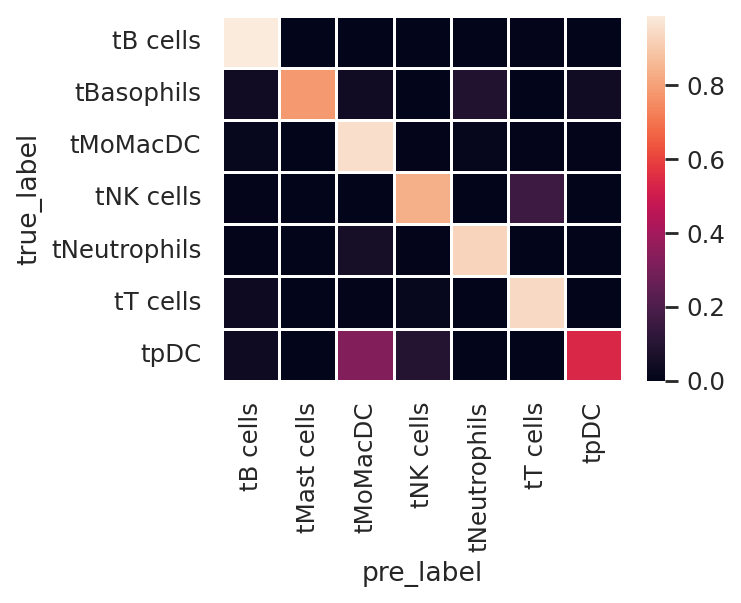

In [81]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# Load the example flights dataset and convert to long-form
flights_long = sns.load_dataset("flights")
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(confuse_matrix_pro ,linewidths=.5, ax=ax)

In [82]:
sns.heatmap(confuse_matrix ,linewidths=.5, ax=ax)

<Axes: xlabel='pre_label', ylabel='true_label'>

In [12]:
adt1 = adt[:adata_species_1.shape[0]]
adt2 = adt[adata_species_1.shape[0]:]
adata_species_1.obs['X_umap_1'] = adt1.obsm['X_umap'][:,0].tolist()
adata_species_1.obs['X_umap_2'] = adt1.obsm['X_umap'][:,1].tolist()

adata_species_2.obs['X_umap_1'] = adt2.obsm['X_umap'][:,0].tolist()
adata_species_2.obs['X_umap_2'] = adt2.obsm['X_umap'][:,1].tolist()
sc.pp.normalize_total(adata_species_1, target_sum=1e6)
sc.pp.log1p(adata_species_1)

sc.pp.normalize_total(adata_species_2, target_sum=1e6)
sc.pp.log1p(adata_species_2)

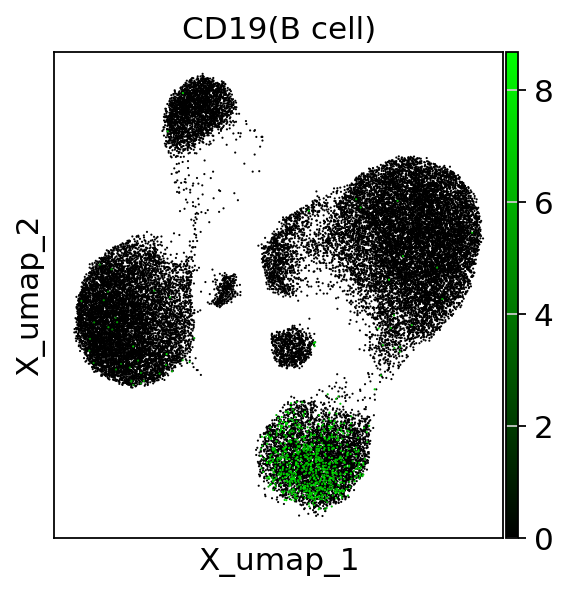

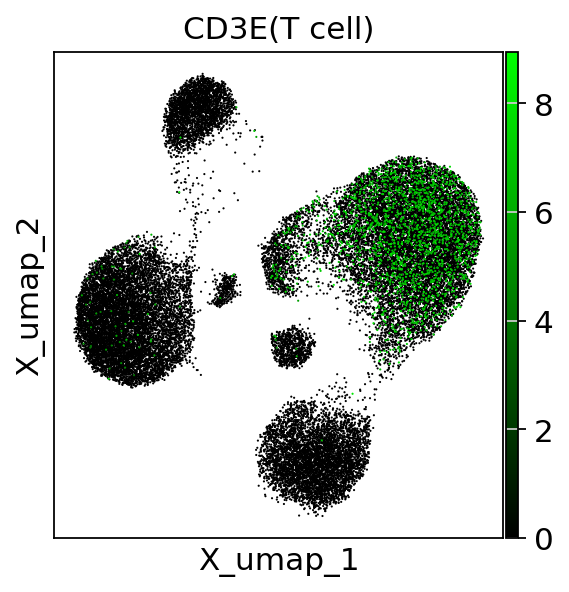

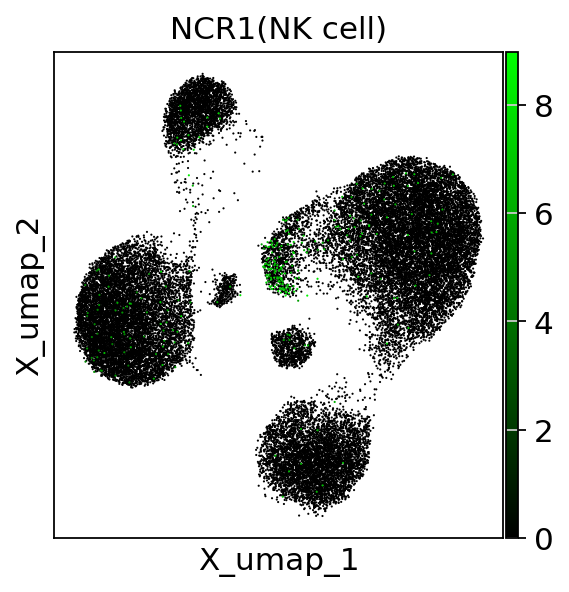

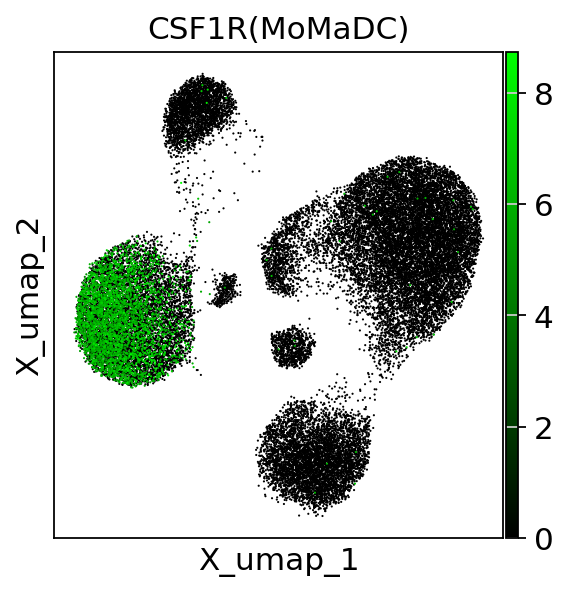

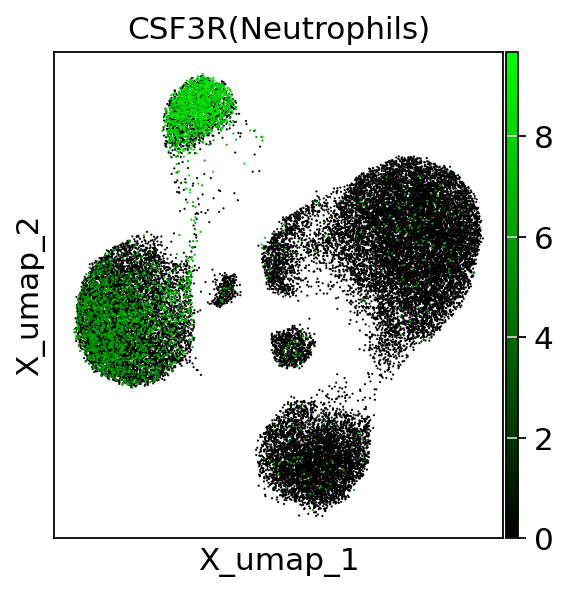

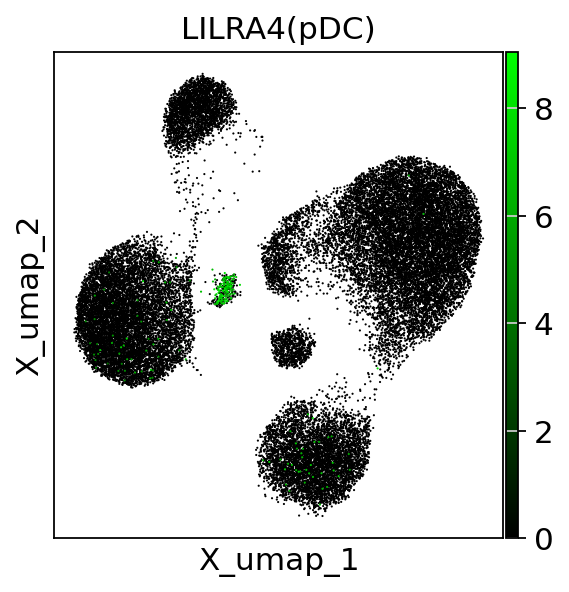

In [15]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# 创建一个颜色映射，0%表达为黑色，100%表达为绿色
sc.set_figure_params(dpi_save=72)
cmap = LinearSegmentedColormap.from_list('custom_green', ['black','#00FF00'], N=256)
genes = ['CD19','CD3E','NCR1','CSF1R','CSF3R','LILRA4']
types = ['B cell','T cell','NK cell','MoMaDC','Neutrophils','pDC']
for gene, type in zip(genes,types):
    ax = sc.pl.scatter(adata_species_1, x='X_umap_1', y='X_umap_2', color=gene,color_map=cmap,  title=f'{gene}({type})',show=False)
    ax.grid(False)  # 去除网格
    # ax.set_frame_on(False)  # 去除边框
    ax.set_xticks([])  # 去除x轴刻度
    ax.set_yticks([])  # 去除y轴刻度
    # ax.set_xticklabels([])  # 去除x轴标签
    # ax.set_yticklabels([])  # 去除y轴标签

    plt.show()

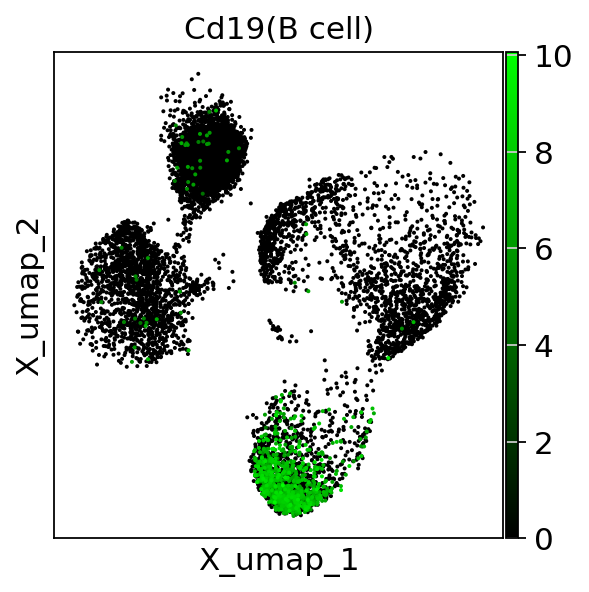

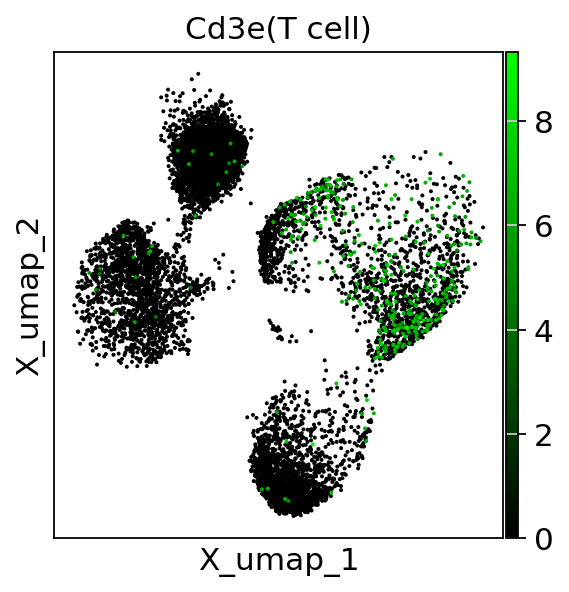

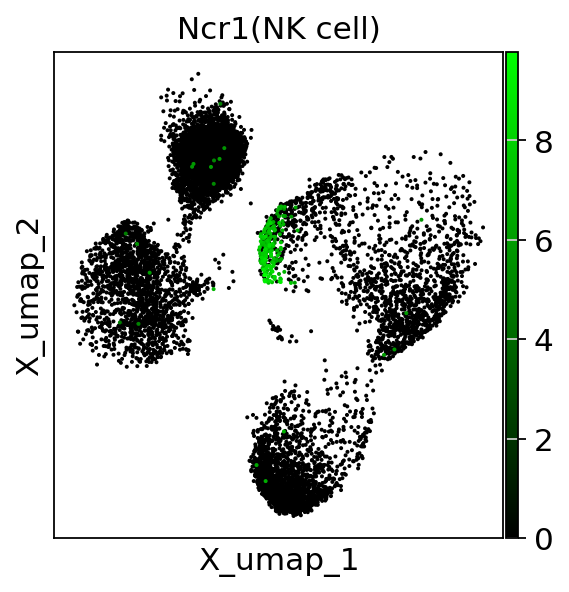

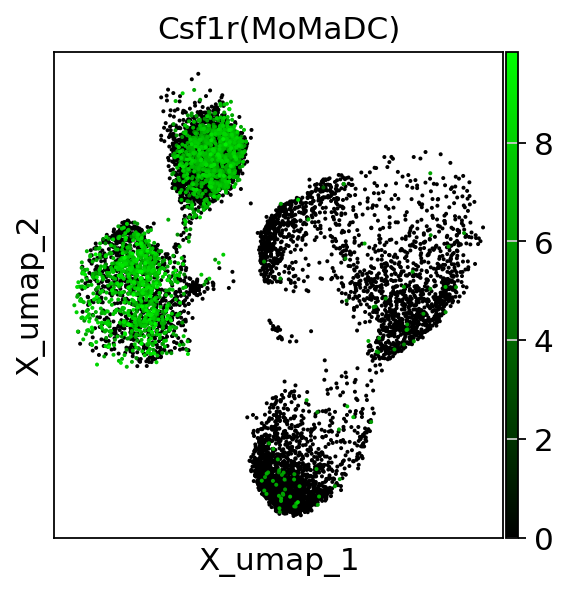

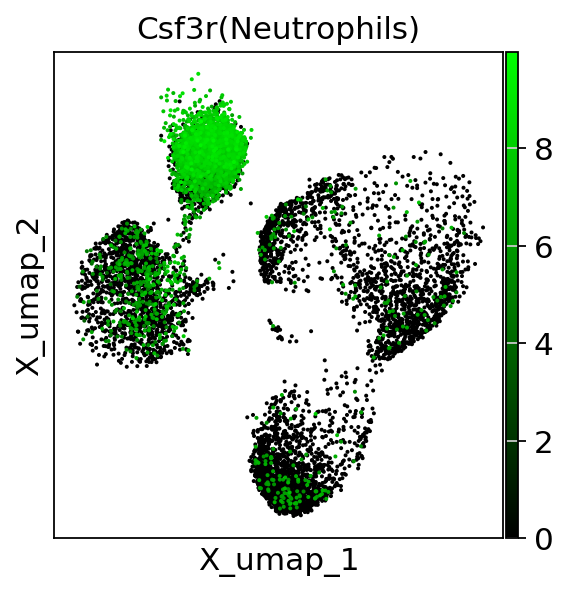

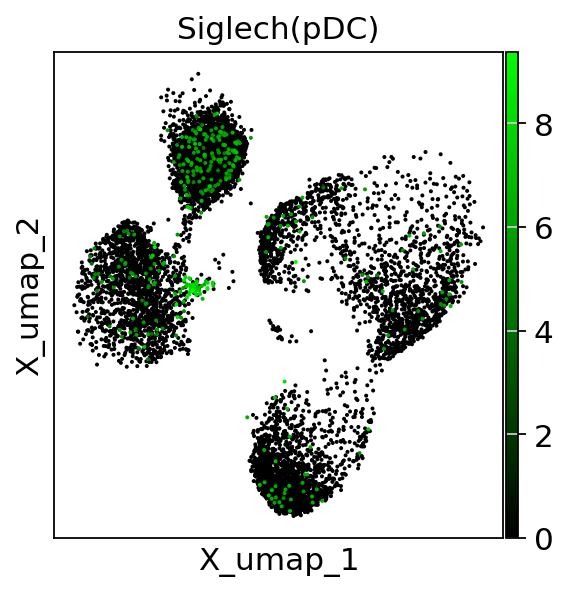

In [16]:
genes = ['Cd19','Cd3e','Ncr1','Csf1r','Csf3r','Siglech']
for gene, type in zip(genes,types):
    ax = sc.pl.scatter(adata_species_2, x='X_umap_1', y='X_umap_2', color=gene,color_map=cmap,  title=f'{gene}({type})',show=False)
    ax.grid(False)  # 去除网格
    # ax.set_frame_on(False)  # 去除边框
    ax.set_xticks([])  # 去除x轴刻度
    ax.set_yticks([])  # 去除y轴刻度
    # ax.set_xticklabels([])  # 去除x轴标签
    # ax.set_yticklabels([])  # 去除y轴标签

    plt.show()